In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import geopandas as gpd
from itertools import combinations as comb
from geopandas.tools import overlay
import os
from sandpyper.common import coords_to_points


from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as ras
from rasterio.plot import show

from sandpyper.sandpyper import ProfileSet
from sandpyper.common import get_sil_location, get_opt_k
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm_notebook as tqdm

pd.options.mode.chained_assignment = None  # default='warn'

crs_dict_string= {
                 'mar': {'init': 'epsg:32754'},
                 'leo':{'init': 'epsg:32755'}
                 }


def kmeans_sa(merged_df, ks, feature_set, thresh_k=5, random_state=10):
    """
    Function to use KMeans on all surveys with the optimal k obtained from the Silhouette Analysis.
    It uses KMeans as a clusterer.

    Args:
        merged_df (Pandas dataframe): The clean and merged dataframe containing the features. Must contain the columns point_id, location and survey_date, as well as the
        ks (int, dict): number of clusters (k) or dictionary containing the optimal k for each survey. See get_opt_k function.
        feature_set (list): List of names of features in the dataframe to use for clustering.
        thresh_k (int): Minimim k to be used. If survey-specific optimal k is below this value, then k equals the average k of all above threshold values.
        random_state (int): Random seed used to make the randomisation deterministic.

    Returns:
        data_classified (pd.DataFrame): A dataframe containing the label_k column, with point_id, location, survey_date and the features used to cluster the data.
    """


    merged_df.dropna(inplace=True)
    list_locs = merged_df.location.unique()

    scaler = MinMaxScaler()
    data_classified = pd.DataFrame()

    # Set a threshold k, in case a k is lower than 5, use the mean optimal k
    # of the other surveys above threshold

    # # Compute the mean optimal k of above threshold ks
    if isinstance(ks, dict):
        arr_k = np.array([i for i in ks.values() if i > thresh_k])
        mean_threshold_k = np.int(np.round(np.mean(arr_k), 0))
    else:
        pass

    for location in tqdm(list_locs):

        list_dates = merged_df.query(f"location=='{location}'").raw_date.unique()

        for survey_date_in in tqdm(list_dates):

            data_in = merged_df.query(
                f"location=='{location}'& raw_date == {survey_date_in}"
            )
            data_clean = data_in[feature_set].apply(pd.to_numeric)

            if isinstance(ks, dict):
                k = ks[f"{location}_{survey_date_in}"]
            else:
                k=ks

            if k < thresh_k:
                k = mean_threshold_k
            else:
                pass

            minmax_scaled_df = scaler.fit_transform(np.nan_to_num(data_clean))

            clusterer = KMeans(
                n_clusters=k,
                init="k-means++",
                algorithm="elkan",
                tol=0.0001,
                random_state=random_state,
            )

            data_in["label_k"] = clusterer.fit_predict(minmax_scaled_df)

            data_classified = pd.concat(
                [data_in, data_classified], ignore_index=True
            )

    return data_classified


def check_dicts_duplicated_values(l_dicts):

    dict_check = {}
    dict_dups = {}
    all_dicts=[dicto for dicto in l_dicts.values()]

    for dict_in in all_dicts:
        for key in set().union(*all_dicts):
            if key in dict_in:
                dict_check.setdefault(key, []).extend(dict_in[key])

    for survey, labels in dict_check.items():
        duplicated=[x for x in labels if labels.count(x) > 1]
        if len(duplicated)>=1:
            dict_dups.update({survey:set(set(duplicated))})

    if len(dict_dups)>0:
        raise ValueError(f"Duplicated label_k found in the following dictionaries.\n\n{dict_dups}\n\nPlease revise and assigned those labels_k to only one class dictionary.")



def classify_labelk(labelled_dataset,l_dicts, cluster_field='label_k', fill_class='sand'):

    check_dicts_duplicated_values(l_dicts)

    labelled_dataset["pt_class"]=np.nan

    all_keys = set().union(*(d.keys() for d in [i for i in l_dicts.values()]))
    class_names=l_dicts.keys()

    classed_df=pd.DataFrame()

    for loc in labelled_dataset.location.unique():
        data_in_loc=labelled_dataset.query(f"location=='{loc}'")[["location","raw_date",cluster_field,"pt_class",'point_id']]

        for raw_date in data_in_loc.raw_date.unique():
            loc_date_tag=f"{loc}_{raw_date}"
            data_in=data_in_loc.query(f"raw_date=={raw_date}")

            if loc_date_tag in all_keys:

                for class_in in class_names:

                    if loc_date_tag in l_dicts[class_in].keys():
                        loc_date_class_values=l_dicts[class_in][loc_date_tag]

                        if len(loc_date_class_values)>=1:
                            tmp_dict={label_k:class_in for label_k in loc_date_class_values}
                            data_in['pt_class'].update(data_in[cluster_field].map(tmp_dict))

                        else:
                            pass
                    else:
                        pass
            else:
                print(f"{loc_date_tag} not in the class dictionaries. All their labels assigned to fill_class {fill_class}.")
                data_in["pt_class"].fillna(fill_class, inplace=True)

            classed_df=pd.concat([classed_df,data_in], ignore_index=True)

    merged=labelled_dataset.iloc[:,:-1].merge(right=classed_df[['point_id','pt_class']], on='point_id', how='left')

    merged["pt_class"].fillna(fill_class, inplace=True)
    return merged


def cleanit(to_clean, l_dicts, cluster_field='label_k', fill_class='sand',
            watermasks_path=None, water_label='water',
            shoremasks_path=None, label_corrections_path=None,
            default_crs={'init': 'epsg:32754'}, crs_dict_string=None,
           geometry_field='coordinates'):

    print("Reclassifying dataset with the provided dictionaries." )
    to_clean_classified=classify_labelk(to_clean, l_dicts)

    if watermasks_path==None and shoremasks_path==None and label_corrections_path==None:
        print("No cleaning polygones have been passed. Returning classified dataset.")
        return to_clean_classified

    processes=[]

    #______ LABELS FINETUNING_______________

    if label_corrections_path != None:
        if os.path.isfile(label_corrections_path):
            label_corrections=gpd.read_file(label_corrections_path)
            print(f"Label corrections provided in CRS: {label_corrections.crs}")
            processes.append("polygon finetuning")
            to_update_finetune=pd.DataFrame()


            for loc in label_corrections.location.unique():
                print(f"Fine tuning in {loc}.")

                to_clean_subset_loc=to_clean_classified.query(f" location == '{loc}'")

                for raw_date in tqdm(label_corrections.query(f"location=='{loc}'").raw_date.unique()):

                    subset_finetune_polys=label_corrections.query(f"location=='{loc}' and raw_date== {raw_date}")

                    for i,row in subset_finetune_polys.iterrows(): # loops through all the polygones

                        target_k=int(row['target_label_k'])
                        new_class=row['new_class']

                        if target_k != 999:
                            data_in=to_clean_subset_loc.query(f"raw_date == {raw_date} and label_k== {target_k}")

                        elif target_k == 999:
                            data_in=to_clean_subset_loc.query(f"raw_date == {raw_date}")

                        selection=data_in[data_in.coordinates.intersects(row.geometry)]

                        if selection.shape[0]==0:
                            selection=data_in[data_in.to_crs(crs_dict_string[loc]).coordinates.intersects(row.geometry)]
                        else:
                            pass
                        selection["finetuned_label"]=new_class

                        print(f"Fine-tuning label_k {target_k} to {new_class} in {loc}-{raw_date}, found {selection.shape[0]} pts.")
                        to_update_finetune=pd.concat([selection,to_update_finetune], ignore_index=True)

            classed_df_finetuned=to_clean_classified.merge(right=to_update_finetune.loc[:,['point_id','finetuned_label']], # Left Join
                                         how='left', validate='one_to_one')

            classed_df_finetuned.finetuned_label.fillna(classed_df_finetuned.pt_class, inplace=True) # Fill NaN with previous sand labels
        else:
            raise NameError("Label correction file path is invalid.")


    else:
        pass

    if shoremasks_path == None and watermasks_path == None:
        print(f"{processes} completed.")

        if 'watermasked_label' in classed_df_finetuned.columns and 'finetuned_label' not in classed_df_finetuned.columns:
            classed_df_finetuned['pt_class']=classed_df_finetuned.watermasked_label
            classed_df_finetuned.drop(['watermasked_label'], axis=1, inplace=True)

        elif 'finetuned_label' in classed_df_finetuned.columns and 'watermasked_label' not in classed_df_finetuned.columns:
            classed_df_finetuned['pt_class']=classed_df_finetuned.finetuned_label
            classed_df_finetuned.drop(['finetuned_label'], axis=1, inplace=True)

        elif 'finetuned_label' in classed_df_finetuned.columns and 'watermasked_label' in classed_df_finetuned.columns:
            classed_df_finetuned['pt_class']=classed_df_finetuned.watermasked_label
            classed_df_finetuned.drop(['finetuned_label','watermasked_label'], axis=1, inplace=True)

        else:
            pass

        return classed_df_finetuned
    else:
        pass

    #______ WATERMASKING_______________

    if watermasks_path != None:
        if os.path.isfile(watermasks_path):
            # apply watermasks
            watermask=gpd.read_file(watermasks_path)
            print(f"watermask  provided in CRS: {watermask.crs}")


            print("Applying watermasks cleaning.")
            processes.append("watermasking")

            if "polygon finetuning" in processes:
                dataset_to_clean=classed_df_finetuned
                starting_labels='finetuned_label'
            else:
                dataset_to_clean=to_clean_classified
                starting_labels='pt_class'


            to_update_watermasked=pd.DataFrame()

            for loc in watermask.location.unique():
                print(f"Watermasking in {loc}.")

                for raw_date in tqdm(watermask.query(f"location=='{loc}'").raw_date.unique()):

                    subset_data=dataset_to_clean.query(f"location=='{loc}' and raw_date == {raw_date}")
                    subset_masks=watermask.query(f"location=='{loc}' and raw_date == {raw_date}")

                    selection=subset_data[subset_data.geometry.intersects(subset_masks.geometry)]
                    if selection.shape[0]==0:
                        selection=subset_data[subset_data.geometry.intersects(subset_masks.to_crs(crs_dict_string[loc]).geometry.any())]
                    else:
                        pass

                    print(f"Setting to {water_label} {selection.shape[0]} pts overlapping provided watermasks.")

                    selection["watermasked_label"]=water_label

                    to_update_watermasked=pd.concat([selection,to_update_watermasked], ignore_index=True)

            classed_df_watermasked=dataset_to_clean.merge(right=to_update_watermasked.loc[:,['point_id','watermasked_label']], # Left Join
                                         how='left', validate='one_to_one')
            classed_df_watermasked.watermasked_label.fillna(classed_df_watermasked.loc[:,starting_labels], inplace=True) # Fill NaN with previous sand labels

            if shoremasks_path == None:
                print(f"{processes} completed.")

                if 'watermasked_label' in classed_df_watermasked.columns and 'finetuned_label' not in classed_df_watermasked.columns:
                    classed_df_watermasked['pt_class']=classed_df_watermasked.watermasked_label
                    classed_df_watermasked.drop(['watermasked_label'], axis=1, inplace=True)

                elif 'finetuned_label' in classed_df_watermasked.columns and 'watermasked_label' not in classed_df_watermasked.columns:
                    classed_df_watermasked['pt_class']=classed_df_watermasked.finetuned_label
                    classed_df_watermasked.drop(['finetuned_label'], axis=1, inplace=True)

                elif 'finetuned_label' in classed_df_watermasked.columns and 'watermasked_label' in classed_df_watermasked.columns:
                    classed_df_watermasked['pt_class']=classed_df_watermasked.watermasked_label
                    classed_df_watermasked.drop(['finetuned_label','watermasked_label'], axis=1, inplace=True)

                else:
                    pass

                return classed_df_watermasked
        else:
            raise NameError("watermask file path is invalid.")

    else:
        pass

    #______ SHOREMASKING_______________

    if shoremasks_path != None:
        if os.path.isfile(shoremasks_path):
            # apply shoremasks
            shoremask=gpd.read_file(shoremasks_path)
            print(f"shoremask  provided in CRS: {shoremask.crs}")
            print("Applying shoremasks cleaning.")
            processes.append("shoremasking")


            if "polygon finetuning" in processes and "watermasking" not in processes:
                dataset_to_clean=classed_df_finetuned
            elif "polygon finetuning" not in processes and "watermasking" in processes:
                dataset_to_clean=classed_df_watermasked
            elif "polygon finetuning"  in processes and "watermasking" in processes:
                dataset_to_clean=classed_df_watermasked
            else:
                dataset_to_clean=to_clean_classified

            inshore_cleaned=gpd.GeoDataFrame()
            for loc in shoremask.location.unique():
                print(f"Shoremasking in {loc}.")

                shore=shoremask.query(f"location=='{loc}'")
                loc_selection=dataset_to_clean.query(f"location=='{loc}'")
                in_shore=loc_selection[loc_selection.geometry.intersects(shore.geometry)]
                if in_shore.shape[0]>=1:
                    pass
                else:
                    in_shore=loc_selection[loc_selection.geometry.intersects(shore.to_crs(crs_dict_string[loc]).geometry.any())]

                print(f"Removing {loc_selection.shape[0] - in_shore.shape[0]} pts falling outside provided shore polygones.")
                inshore_cleaned=pd.concat([in_shore,inshore_cleaned], ignore_index=True)

            print(f"{processes} completed.")

            if 'watermasked_label' in inshore_cleaned.columns and 'finetuned_label' not in inshore_cleaned.columns:
                inshore_cleaned['pt_class']=inshore_cleaned.watermasked_label
                inshore_cleaned.drop(['watermasked_label'], axis=1, inplace=True)

            elif 'finetuned_label' in inshore_cleaned.columns and 'watermasked_label' not in inshore_cleaned.columns:
                inshore_cleaned['pt_class']=inshore_cleaned.finetuned_label
                inshore_cleaned.drop(['finetuned_label'], axis=1, inplace=True)

            elif 'finetuned_label' in inshore_cleaned.columns and 'watermasked_label' in inshore_cleaned.columns:
                inshore_cleaned['pt_class']=inshore_cleaned.watermasked_label
                inshore_cleaned.drop(['finetuned_label','watermasked_label'], axis=1, inplace=True)

            else:
                pass

            return inshore_cleaned
        else:
            raise NameError("shoremask file path is invalid.")

C:\anaconda3\envs\sandpyper_env\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\anaconda3\envs\sandpyper_env\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
water_dict={'leo_20180606':[0,9,10],
'leo_20180713':[0,3,4,7],
'leo_20180920':[0,2,6,7],
'leo_20190211':[0,2,5],
'leo_20190328':[2,4,5],
'leo_20190731':[0,2,8,6],
'mar_20180601':[1,6],
'mar_20180621':[4,6],
'mar_20180727':[0,5,9,10],
'mar_20180925':[6],
'mar_20181113':[1],
'mar_20181211':[4],
'mar_20190205':[],
'mar_20190313':[],
'mar_20190516':[4,7]}

no_sand_dict={'leo_20180606':[5],
'leo_20180713':[],
'leo_20180920':[],
'leo_20190211':[1],
'leo_20190328':[],
'leo_20190731':[1],
'mar_20180601':[4,5],
'mar_20180621':[3,5],
'mar_20180727':[4,7],
'mar_20180925':[5],
'mar_20181113':[0],
'mar_20181211':[0],
'mar_20190205':[0,5],
'mar_20190313':[4],
'mar_20190516':[2,5]}

veg_dict={'leo_20180606':[1,3,7,8],
'leo_20180713':[1,5,9],
'leo_20180920':[1,4,5],
'leo_20190211':[4],
'leo_20190328':[0,1,6],
'leo_20190731':[3,7],
'mar_20180601':[0,7],
'mar_20180621':[1,7],
'mar_20180727':[1,3],
'mar_20180925':[1,3],
'mar_20181113':[3],
'mar_20181211':[2],
'mar_20190205':[3],
'mar_20190313':[1,5],
'mar_20190516':[0]}

sand_dict={'leo_20180606':[2,4,6],
'leo_20180713':[2,6,8],
'leo_20180920':[3],
'leo_20190211':[3],
'leo_20190328':[3],
'leo_20190731':[4,5],
'mar_20180601':[2,3],
'mar_20180621':[0,2],
'mar_20180727':[2,6,8],
'mar_20180925':[0,4,2],
'mar_20181113':[2,4],
'mar_20181211':[3,1],
'mar_20190205':[1,2,4],
'mar_20190313':[0,2,3],
'mar_20190516':[1,3,6]}

l_dicts={'no_sand': no_sand_dict,
         'sand': sand_dict,
        'water': water_dict,
        'veg':veg_dict}# set the path to the test data folder
test_data_folder = r"C:\my_packages\sandpyper\examples\test_data"

# the paths to the DSM, orthophotos and transect directories
dirNameDSM=Path(test_data_folder + r"\dsm_1m")
dirNameOrtho=Path(test_data_folder + r"\orthos_1m")
dirNameTrans=Path(test_data_folder + r"\transects")

# path to the LoD transects

lod_mode=Path(test_data_folder + r"\lod_transects")


# the location codes used for the monitored locations
loc_codes=["mar","leo"]


# the keyword search dictionary
loc_search_dict = {   'leo': ['St','Leonards','leonards','leo'],
                   'mar': ['Marengo','marengo','mar'] }


# the EPSG codes of the coordinate reference systems for each location code (location) given in CRS string format
crs_dict_string= {
                 'mar': {'init': 'epsg:32754'},
                 'leo':{'init': 'epsg:32755'}
                 }

# the transect spacing of the transects
transects_spacing=20

In [3]:
# set the path to the test data folder
test_data_folder = r"C:\my_packages\sandpyper\examples\test_data"

# the paths to the DSM, orthophotos and transect directories
dirNameDSM=Path(test_data_folder + r"\dsm_1m")
dirNameOrtho=Path(test_data_folder + r"\orthos_1m")
dirNameTrans=Path(test_data_folder + r"\transects")

# path to the LoD transects

lod_mode=Path(test_data_folder + r"\lod_transects")


# the location codes used for the monitored locations
loc_codes=["mar","leo"]


# the keyword search dictionary
loc_search_dict = {   'leo': ['St','Leonards','leonards','leo'],
                   'mar': ['Marengo','marengo','mar'] }


# the transect spacing of the transects
transects_spacing=20

In [4]:
P=ProfileSet(dirNameDSM=dirNameDSM,
            dirNameOrtho=dirNameOrtho,
            dirNameTrans=dirNameTrans,
            transects_spacing=transects_spacing,
            loc_codes=loc_codes,
            loc_search_dict=loc_search_dict,
            crs_dict_string=crs_dict_string,
            check="all")

# run extraction from DSMs and orthos with 1m sampling steps and add X and Y fields to output geodataframe.
# use LoDs profiles provided.

P.extract_profiles(mode='all',tr_ids='tr_id',sampling_step=1,add_xy=True,lod_mode=lod_mode)

# Run interatively KMeans + SA using the feature_set provided
#feel free to add 

feature_set=["band1","band2","band3","distance"]
sil_df=get_sil_location(P.profiles,
                        ks=(2,15), 
                        feature_set=feature_set,
                       random_state=10)

opt_k=get_opt_k(sil_df, sigma=0 )
opt_k

C:\anaconda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


C:\my_packages\sandpyper\examples\test_data\dsm_1m
C:\my_packages\sandpyper\examples\test_data\orthos_1m
dsm from leo = 6

ortho from leo = 6

dsm from mar = 9

ortho from mar = 9


umber OF DATASETS TO PROCESS: 30
Extracting elevation from DSMs . . .


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Extraction successful
Number of points extracted:32805
Time for processing=39.72982096672058 seconds
First 10 rows are printed below
Number of points outside the raster extents: 9066
The extraction assigns NaN.
Number of points in NoData areas within the raster extents: 250
The extraction assigns NaN.
Extracting rgb values from orthos . . .


  0%|          | 0/15 [00:00<?, ?it/s]

C:\anaconda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Extraction successful
Number of points extracted:32805
Time for processing=43.90751624107361 seconds
First 10 rows are printed below
Number of points outside the raster extents: 27198
The extraction assigns NaN.
Number of points in NoData areas within the raster extents: 0
The extraction assigns NaN.
Extracting LoD values


  0%|          | 0/15 [00:00<?, ?it/s]

C:\anaconda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Extraction successful
Number of points extracted:1395
Time for processing=5.094757318496704 seconds
First 10 rows are printed below
Number of points outside the raster extents: 27
The extraction assigns NaN.
Number of points in NoData areas within the raster extents: 0
The extraction assigns NaN.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Working on : mar, 20190516.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.6219865168763407
For n_clusters = 3 The average silhouette_score is : 0.535782834177223
For n_clusters = 4 The average silhouette_score is : 0.5360693626824162
For n_clusters = 5 The average silhouette_score is : 0.4560535847617118
For n_clusters = 6 The average silhouette_score is : 0.45529082978244856
For n_clusters = 7 The average silhouette_score is : 0.44623104595368007
For n_clusters = 8 The average silhouette_score is : 0.4276467073078296
For n_clusters = 9 The average silhouette_score is : 0.39984472497160034
For n_clusters = 10 The average silhouette_score is : 0.3944833658664287
For n_clusters = 11 The average silhouette_score is : 0.39290037915600995
For n_clusters = 12 The average silhouette_score is : 0.3626866522843635
For n_clusters = 13 The average silhouette_score is : 0.3537214969510808
For n_clusters = 14 The average silhouette_score is : 0.360049558138258
Working on : mar, 20190313.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.557958595647791
For n_clusters = 3 The average silhouette_score is : 0.5140648301846097
For n_clusters = 4 The average silhouette_score is : 0.5018436513556769
For n_clusters = 5 The average silhouette_score is : 0.433979206893076
For n_clusters = 6 The average silhouette_score is : 0.417124057365699
For n_clusters = 7 The average silhouette_score is : 0.41877526043796687
For n_clusters = 8 The average silhouette_score is : 0.3813644990945346
For n_clusters = 9 The average silhouette_score is : 0.38298598316290156
For n_clusters = 10 The average silhouette_score is : 0.38780357139523025
For n_clusters = 11 The average silhouette_score is : 0.3705944933198418
For n_clusters = 12 The average silhouette_score is : 0.3651637741592011
For n_clusters = 13 The average silhouette_score is : 0.3626901435079943
For n_clusters = 14 The average silhouette_score is : 0.364312347054231
Working on : mar, 20190205.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5864811907668233
For n_clusters = 3 The average silhouette_score is : 0.5287826504696901
For n_clusters = 4 The average silhouette_score is : 0.5135421029464969
For n_clusters = 5 The average silhouette_score is : 0.4307716357147362
For n_clusters = 6 The average silhouette_score is : 0.4198951039452866
For n_clusters = 7 The average silhouette_score is : 0.4216561839748987
For n_clusters = 8 The average silhouette_score is : 0.4048963177852256
For n_clusters = 9 The average silhouette_score is : 0.40309220394346107
For n_clusters = 10 The average silhouette_score is : 0.3863324302013023
For n_clusters = 11 The average silhouette_score is : 0.3797930282754271
For n_clusters = 12 The average silhouette_score is : 0.38096229910474133
For n_clusters = 13 The average silhouette_score is : 0.38270148296414735
For n_clusters = 14 The average silhouette_score is : 0.38101196831610196
Working on : mar, 20181211.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5408421089322027
For n_clusters = 3 The average silhouette_score is : 0.5230591336669079
For n_clusters = 4 The average silhouette_score is : 0.5212604455141028
For n_clusters = 5 The average silhouette_score is : 0.4229400387683722
For n_clusters = 6 The average silhouette_score is : 0.45245862927127983
For n_clusters = 7 The average silhouette_score is : 0.4483238394769186
For n_clusters = 8 The average silhouette_score is : 0.4196417680949735
For n_clusters = 9 The average silhouette_score is : 0.40611511715414134
For n_clusters = 10 The average silhouette_score is : 0.38659542553842996
For n_clusters = 11 The average silhouette_score is : 0.3696055524901218
For n_clusters = 12 The average silhouette_score is : 0.37009962399500085
For n_clusters = 13 The average silhouette_score is : 0.35527656663572244
For n_clusters = 14 The average silhouette_score is : 0.3465435289160837
Working on : mar, 20181113.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5653353599190023
For n_clusters = 3 The average silhouette_score is : 0.48082172651613736
For n_clusters = 4 The average silhouette_score is : 0.4739355249881875
For n_clusters = 5 The average silhouette_score is : 0.44998542160594424
For n_clusters = 6 The average silhouette_score is : 0.46793686792032685
For n_clusters = 7 The average silhouette_score is : 0.45141377362406754
For n_clusters = 8 The average silhouette_score is : 0.4282875609756635
For n_clusters = 9 The average silhouette_score is : 0.41407851845524357
For n_clusters = 10 The average silhouette_score is : 0.40718423656045105
For n_clusters = 11 The average silhouette_score is : 0.3903647922431344
For n_clusters = 12 The average silhouette_score is : 0.3839833647433829
For n_clusters = 13 The average silhouette_score is : 0.38065272471925277
For n_clusters = 14 The average silhouette_score is : 0.3832072967705472
Working on : mar, 20180925.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5781993163219185
For n_clusters = 3 The average silhouette_score is : 0.5170856406873439
For n_clusters = 4 The average silhouette_score is : 0.48466929384434043
For n_clusters = 5 The average silhouette_score is : 0.4373504056027659
For n_clusters = 6 The average silhouette_score is : 0.39375906953445383
For n_clusters = 7 The average silhouette_score is : 0.38864190848914665
For n_clusters = 8 The average silhouette_score is : 0.4035256487664215
For n_clusters = 9 The average silhouette_score is : 0.3798356038299367
For n_clusters = 10 The average silhouette_score is : 0.37962054426443537
For n_clusters = 11 The average silhouette_score is : 0.3644375001522226
For n_clusters = 12 The average silhouette_score is : 0.3558265298038209
For n_clusters = 13 The average silhouette_score is : 0.34528697717595713
For n_clusters = 14 The average silhouette_score is : 0.35004508855406896
Working on : mar, 20180727.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5803251747670938
For n_clusters = 3 The average silhouette_score is : 0.48850610227959923
For n_clusters = 4 The average silhouette_score is : 0.4772654299979584
For n_clusters = 5 The average silhouette_score is : 0.4135001777584117
For n_clusters = 6 The average silhouette_score is : 0.38283314263428714
For n_clusters = 7 The average silhouette_score is : 0.3755827513627956
For n_clusters = 8 The average silhouette_score is : 0.3486272625814806
For n_clusters = 9 The average silhouette_score is : 0.3367906257895182
For n_clusters = 10 The average silhouette_score is : 0.3273888373123684
For n_clusters = 11 The average silhouette_score is : 0.30071888963336296
For n_clusters = 12 The average silhouette_score is : 0.3219840164575009
For n_clusters = 13 The average silhouette_score is : 0.3222155159146202
For n_clusters = 14 The average silhouette_score is : 0.307958370621084
Working on : mar, 20180621.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.5439589764752933
For n_clusters = 3 The average silhouette_score is : 0.4387708619085413
For n_clusters = 4 The average silhouette_score is : 0.4501935908699898
For n_clusters = 5 The average silhouette_score is : 0.3963414382040067
For n_clusters = 6 The average silhouette_score is : 0.41807731086369254
For n_clusters = 7 The average silhouette_score is : 0.3871968978951222
For n_clusters = 8 The average silhouette_score is : 0.37393061831106983
For n_clusters = 9 The average silhouette_score is : 0.3443142601476958
For n_clusters = 10 The average silhouette_score is : 0.3585650473719073
For n_clusters = 11 The average silhouette_score is : 0.35570748604269775
For n_clusters = 12 The average silhouette_score is : 0.3575633171508779
For n_clusters = 13 The average silhouette_score is : 0.37087632012718563
For n_clusters = 14 The average silhouette_score is : 0.3795271430686032
Working on : mar, 20180601.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.48270415311106846
For n_clusters = 3 The average silhouette_score is : 0.3772084152830261
For n_clusters = 4 The average silhouette_score is : 0.38234628609235827
For n_clusters = 5 The average silhouette_score is : 0.38128225187445997
For n_clusters = 6 The average silhouette_score is : 0.36428432858349613
For n_clusters = 7 The average silhouette_score is : 0.36240034713437685
For n_clusters = 8 The average silhouette_score is : 0.3701424025696913
For n_clusters = 9 The average silhouette_score is : 0.37175207788683484
For n_clusters = 10 The average silhouette_score is : 0.37676977350569846
For n_clusters = 11 The average silhouette_score is : 0.37582649170780724
For n_clusters = 12 The average silhouette_score is : 0.3619596723553155
For n_clusters = 13 The average silhouette_score is : 0.360705274650356
For n_clusters = 14 The average silhouette_score is : 0.3549151019500089


  0%|          | 0/6 [00:00<?, ?it/s]

Working on : leo, 20190731.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.3899198233106219
For n_clusters = 3 The average silhouette_score is : 0.5071438060156596
For n_clusters = 4 The average silhouette_score is : 0.47005119135652856
For n_clusters = 5 The average silhouette_score is : 0.4481907289981238
For n_clusters = 6 The average silhouette_score is : 0.42502882450684076
For n_clusters = 7 The average silhouette_score is : 0.4011433092740131
For n_clusters = 8 The average silhouette_score is : 0.38998808479733066
For n_clusters = 9 The average silhouette_score is : 0.38559916622535073
For n_clusters = 10 The average silhouette_score is : 0.38736594985557654
For n_clusters = 11 The average silhouette_score is : 0.3788805356672864
For n_clusters = 12 The average silhouette_score is : 0.37132878563783606
For n_clusters = 13 The average silhouette_score is : 0.3728000521740459
For n_clusters = 14 The average silhouette_score is : 0.37291633707910765
Working on : leo, 20190328.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.3988524141238273
For n_clusters = 3 The average silhouette_score is : 0.4304685615621422
For n_clusters = 4 The average silhouette_score is : 0.431227035737659
For n_clusters = 5 The average silhouette_score is : 0.4509750902886234
For n_clusters = 6 The average silhouette_score is : 0.42012497505273527
For n_clusters = 7 The average silhouette_score is : 0.4094032569946379
For n_clusters = 8 The average silhouette_score is : 0.42729379253757904
For n_clusters = 9 The average silhouette_score is : 0.41690585873078206
For n_clusters = 10 The average silhouette_score is : 0.4226788217215935
For n_clusters = 11 The average silhouette_score is : 0.41351261817558693
For n_clusters = 12 The average silhouette_score is : 0.4087415403998031
For n_clusters = 13 The average silhouette_score is : 0.38543846003780563
For n_clusters = 14 The average silhouette_score is : 0.3783301865582882
Working on : leo, 20190211.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.3811803323084047
For n_clusters = 3 The average silhouette_score is : 0.48727929000883047
For n_clusters = 4 The average silhouette_score is : 0.44313687819005354
For n_clusters = 5 The average silhouette_score is : 0.45097582364485633
For n_clusters = 6 The average silhouette_score is : 0.4320727369612193
For n_clusters = 7 The average silhouette_score is : 0.4166514336483687
For n_clusters = 8 The average silhouette_score is : 0.39445247084076124
For n_clusters = 9 The average silhouette_score is : 0.3718047003108205
For n_clusters = 10 The average silhouette_score is : 0.36905766574894283
For n_clusters = 11 The average silhouette_score is : 0.3723670925736636
For n_clusters = 12 The average silhouette_score is : 0.35518841237259613
For n_clusters = 13 The average silhouette_score is : 0.35415290301652735
For n_clusters = 14 The average silhouette_score is : 0.33383141602938693
Working on : leo, 20180920.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.4039166622963731
For n_clusters = 3 The average silhouette_score is : 0.4367493135688848
For n_clusters = 4 The average silhouette_score is : 0.42434419318841404
For n_clusters = 5 The average silhouette_score is : 0.4443994359362926
For n_clusters = 6 The average silhouette_score is : 0.4175864662989779
For n_clusters = 7 The average silhouette_score is : 0.38860870508958795
For n_clusters = 8 The average silhouette_score is : 0.38880003508342514
For n_clusters = 9 The average silhouette_score is : 0.3830287983992327
For n_clusters = 10 The average silhouette_score is : 0.37353163965128733
For n_clusters = 11 The average silhouette_score is : 0.36620965721819637
For n_clusters = 12 The average silhouette_score is : 0.3536600836899299
For n_clusters = 13 The average silhouette_score is : 0.3585083805642395
For n_clusters = 14 The average silhouette_score is : 0.35672016047028215
Working on : leo, 20180713.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.49629965872244686
For n_clusters = 3 The average silhouette_score is : 0.5092406492417487
For n_clusters = 4 The average silhouette_score is : 0.46159478658042724
For n_clusters = 5 The average silhouette_score is : 0.4488595142176017
For n_clusters = 6 The average silhouette_score is : 0.4183623304561938
For n_clusters = 7 The average silhouette_score is : 0.39004221840210485
For n_clusters = 8 The average silhouette_score is : 0.3842278112748862
For n_clusters = 9 The average silhouette_score is : 0.36304035595403583
For n_clusters = 10 The average silhouette_score is : 0.3463760386521644
For n_clusters = 11 The average silhouette_score is : 0.34841430296451464
For n_clusters = 12 The average silhouette_score is : 0.3460546307634773
For n_clusters = 13 The average silhouette_score is : 0.34457917043266856
For n_clusters = 14 The average silhouette_score is : 0.3318667826222712
Working on : leo, 20180606.


  0%|          | 0/13 [00:00<?, ?it/s]

For n_clusters = 2 The average silhouette_score is : 0.4012079287817844
For n_clusters = 3 The average silhouette_score is : 0.4563078554750914
For n_clusters = 4 The average silhouette_score is : 0.40640166442880776
For n_clusters = 5 The average silhouette_score is : 0.4001757072050638
For n_clusters = 6 The average silhouette_score is : 0.3890044660503746
For n_clusters = 7 The average silhouette_score is : 0.3716889344520391
For n_clusters = 8 The average silhouette_score is : 0.36600629265911533
For n_clusters = 9 The average silhouette_score is : 0.3503569988098764
For n_clusters = 10 The average silhouette_score is : 0.34651080656561367
For n_clusters = 11 The average silhouette_score is : 0.34322073624826754
For n_clusters = 12 The average silhouette_score is : 0.3439561998875081
For n_clusters = 13 The average silhouette_score is : 0.347961415981389
For n_clusters = 14 The average silhouette_score is : 0.33782737875946023


{'leo_20180606': 11,
 'leo_20180713': 10,
 'leo_20180920': 4,
 'leo_20190211': 4,
 'leo_20190328': 7,
 'leo_20190731': 9,
 'mar_20180601': 3,
 'mar_20180621': 3,
 'mar_20180727': 11,
 'mar_20180925': 7,
 'mar_20181113': 5,
 'mar_20181211': 5,
 'mar_20190205': 6,
 'mar_20190313': 6,
 'mar_20190516': 3}

In [ ]:
opt_k_broke={'leo_20180606': 10,
 'leo_20180713': 10,
 'leo_20180920': 10,
 'leo_20190211': 10,
 'leo_20190328': 10,
 'leo_20190731': 10,
 'mar_20180601': 10,
 'mar_20180621': 10,
 'mar_20180727': 10,
 'mar_20180925': 10,
 'mar_20181113': 10,
 'mar_20181211': 10,
 'mar_20190205': 10,
 'mar_20190313': 10,
 'mar_20190516': 10}

In [ ]:
profiles=pd.read_csv(r"C:\my_packages\tmp\check_cleanit.csv")
profiles

In [17]:
a=P.profiles.copy()

In [14]:
feature_set=["band1","band2","band3","distance"]

prof_works=kmeans_sa(a, ks=opt_k,feature_set=feature_set )
#prof_broke=kmeans_sa(profiles, ks=opt_k_broke,feature_set=feature_set )

C:\new_temp/ipykernel_33612/322651387.py:60: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mean_threshold_k = np.int(np.round(np.mean(arr_k), 0))


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
from sandpyper.common import coords_to_points

prof_broke['coordinates']=prof_broke.coordinates.apply(coords_to_points)

In [ ]:
cluster_field='label_k'
fill_class='ciao'
watermasks_path=None
water_label='ciao'
shoremasks_path=None
label_corrections_path=None
default_crs={'init': 'epsg:32754'}
crs_dict_string=None
geometry_field='coordinates'

In [ ]:
# the EPSG codes of the coordinate reference systems for each location code (location) given in CRS string format
crs_dict_string= {
                 'mar': {'init': 'epsg:32754'},
                 'leo':{'init': 'epsg:32755'}
                 }


prof_broke=gpd.GeoDataFrame(prof_broke, crs=crs_dict_string['mar'], geometry='coordinates')

In [5]:

label_corrections_path=Path(test_data_folder + r"\clean\label_corrections.gpkg")
watermasks_path=Path(test_data_folder + r"\clean\watermasks.gpkg")
shoremasks_path=Path(test_data_folder + r"\clean\shoremasks.gpkg")

In [7]:
profiles=P.profiles.copy()

In [ ]:
P.

In [8]:
print("Reclassifying dataset with the provided dictionaries." )
to_clean_classified=classify_labelk(profiles, l_dicts)

Reclassifying dataset with the provided dictionaries.


KeyError: "['label_k'] not in index"

In [ ]:

if watermasks_path==None and shoremasks_path==None and label_corrections_path==None:
    print("No cleaning polygones have been passed. Returning classified dataset.")

processes=[]

#______ LABELS FINETUNING_______________

if label_corrections_path != None:
    if os.path.isfile(label_corrections_path):
        label_corrections=gpd.read_file(label_corrections_path)
        print(f"Label corrections provided in CRS: {label_corrections.crs}")
        processes.append("polygon finetuning")
        to_update_finetune=pd.DataFrame()


        for loc in label_corrections.location.unique():
            print(f"Fine tuning in {loc}.")

            to_clean_subset_loc=to_clean_classified.query(f" location == '{loc}'")

            for raw_date in tqdm(label_corrections.query(f"location=='{loc}'").raw_date.unique()):

                subset_finetune_polys=label_corrections.query(f"location=='{loc}' and raw_date== {raw_date}")
                print(loc)
                print(raw_date)

                for i,row in subset_finetune_polys.iterrows(): # loops through all the polygones

                    target_k=int(row['target_label_k'])
                    new_class=row['new_class']
                    print(target_k)
                    print(new_class)

                    if target_k != 999:
                        data_in=to_clean_subset_loc.query(f"raw_date == {raw_date} and label_k== {target_k}")

                    elif target_k == 999:
                        data_in=to_clean_subset_loc.query(f"raw_date == {raw_date}")

                    selection=data_in[data_in.coordinates.intersects(row.geometry)]

                    if selection.shape[0]==0:
                        selection=data_in[data_in.to_crs(crs_dict_string[loc]).coordinates.intersects(row.geometry)]
                        
                        if selection.shape[0]==0:
                            print(f"The label correction file provids polygons to transform label_k {target_k} into {new_class} in {loc} in date {raw_date}, but these polygons do not overlap any points with such target k! Double check your files if this is unwanted.")
                        else:
                            pass
                    else:
                        pass
                    selection["finetuned_label"]=new_class

                    print(f"Fine-tuning label_k {target_k} to {new_class} in {loc}-{raw_date}, found {selection.shape[0]} pts.")
                    to_update_finetune=pd.concat([selection,to_update_finetune], ignore_index=True)

        classed_df_finetuned=to_clean_classified.merge(right=to_update_finetune.loc[:,['point_id','finetuned_label']], # Left Join
                                     how='left', validate='one_to_one')

        classed_df_finetuned.finetuned_label.fillna(classed_df_finetuned.pt_class, inplace=True) # Fill NaN with previous sand labels
    else:
        raise NameError("Label correction file path is invalid.")


else:
    pass

In [ ]:
for loc in label_corrections.query("location=='leo' and raw_date==20190731").location.unique():
    print(loc)
    for raw_date in label_corrections.query("location=='leo' and raw_date==20190731").raw_date.unique():
        print(f"Check raw_date {raw_date}")
        for target_label_k in label_corrections.query(f"raw_date=={raw_date}").target_label_k.unique():
            print(f"Check target_label_k {target_label_k}")

            date_labelk_subset=label_corrections.query(f"raw_date=={raw_date} and target_label_k=={int(target_label_k)}")

            # if more than one polygons target the same label k, check if they overlap
            if len(date_labelk_subset)>1:
                print(f"There are {len(date_labelk_subset)} corr polys")

                # check if there are any one of them that overlaps       
                for i,z in comb(range(len(date_labelk_subset)),2):
                    intersection_gdf = overlay(date_labelk_subset.iloc[[i]], date_labelk_subset.iloc[[z]], how='intersection')

                    if not intersection_gdf.empty:

                        # check if the overlapping polygons have assigns different new_classes 
                        if any(intersection_gdf.new_class_1 != intersection_gdf.new_class_2):

                            # if overlap areas assign different classes, check if this area contains points.
                            # if contains points, raise an error as it does not make sense and the polygons must be corrected
                            # by the user

                            pts=profiles.query(f"location=='{loc}' and raw_date=={raw_date}")
                            pts['coordinates']=pts.coordinates.apply(coords_to_points)
                            pts_gdf=gpd.GeoDataFrame(pts, geometry='coordinates', crs=crs_dict_string[loc])
                            
                            fully_contains = [intersection_gdf.geometry.contains(mask_geom)[0] for mask_geom in pts_gdf.geometry]

                            if True in fully_contains:
                                idx_true=[i for i, x in enumerate(fully_contains) if x]
                                raise ValueError(f"There are {len(intersection_gdf)} overlapping polygons in {loc} raw_date {raw_date} targeting label_k = {target_label_k} that assign to the same points different the classes {intersection_gdf.loc[:,'new_class_1'][0], intersection_gdf.loc[:,'new_class_2'][0]}. This doesn't make sense, please correct your label correction polygons. You can have overlapping polygons which act on the same target label k, but in this case they MUST assign the same new class to these points.")

print("Check terminated successfully")

In [21]:
label_corrections=gpd.read_file(label_corrections_path)

C:\anaconda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [ ]:
f,ax=plt.subplots()
pts_gdf.plot(ax=ax)
intersection_gdf.boundary.plot(ax=ax, color='r')

In [58]:
label_corrections=label_corrections
profiles=prof_works
crs=crs_dict_string

for loc in label_corrections.location.unique():
    for raw_date in label_corrections.query(f"location=='{loc}'").raw_date.unique():
        for target_label_k in label_corrections.query(f"location=='{loc}' and raw_date=={raw_date}").target_label_k.unique():

            date_labelk_subset=label_corrections.query(f"location=='{loc}' and raw_date=={raw_date} and target_label_k=={int(target_label_k)}")

            # if more than one polygons target the same label k, check if they overlap
            if len(date_labelk_subset)>1:

                # check if there are any one of them that overlaps
                for i,z in comb(range(len(date_labelk_subset)),2):
                    intersection_gdf = overlay(date_labelk_subset.iloc[[i]], date_labelk_subset.iloc[[z]], how='intersection')

                    if not intersection_gdf.empty:

                       # check if the overlapping polygons have assigns different new_classes
                        if any(intersection_gdf.new_class_1 != intersection_gdf.new_class_2):

                            # if overlap areas assign different classes, check if this area contains points with label_k equal to both polygons target_label_k..
                            # if contains points, raise an error as it does not make sense and the polygons must be corrected
                            # by the user

                            pts=profiles.query(f"location=='{loc}' and raw_date=={raw_date} and label_k={int(label_k)}")

                            if isinstance(pts.iloc[0]['coordinates'],Point):
                                pts_gdf=pts
                            elif isinstance(pts.iloc[0]['coordinates'],str):
                                pts['coordinates']=pts.coordinates.apply(coords_to_points)
                                if isinstance(crs, dict):
                                    pts_gdf=gpd.GeoDataFrame(pts, geometry='coordinates', crs=crs[loc])
                                elif isinstance(crs, int):
                                    crs_adhoc={'init': f'epsg:{crs}'}
                                    pts_gdf=gpd.GeoDataFrame(pts, geometry='coordinates', crs=crs_adhoc)
                            else:
                                raise ValueError(f"profiles coordinates field must contain points coordinates either as Shapely Point geometry objects or as a string representing a Shapely Point geometry in well known text. Found {type(pts.iloc[0]['coordinates'])} type instead.")

                            fully_contains = [intersection_gdf.geometry.contains(mask_geom)[0] for mask_geom in pts_gdf.geometry]

                            if True in fully_contains:
                                idx_true=[i for i, x in enumerate(fully_contains) if x]
                                raise ValueError(f"There are {len(intersection_gdf)} points in the overlap area of two label correction polygons (location: {loc}, raw_date: {raw_date}, target_label_k = {target_label_k}) which assign two different classes: {intersection_gdf.loc[:,'new_class_1'][0], intersection_gdf.loc[:,'new_class_2'][0]}. This doesn't make sense, please correct your label correction polygons. You can have overlapping polygons which act on the same target label k, but if they overlap points with such target_label_k, then they MUST assign the same new class.")

print("Check label correction polygons overlap inconsistencies terminated successfully")

NameError: name 'label_k' is not defined

In [55]:
intersection_gdf.contains()

,location_1,raw_date_1,target_label_k_1,new_class_1,location_2,raw_date_2,target_label_k_2,new_class_2,geometry
0,leo,20190731,6,sand,leo,20190731,6,veg,"MULTIPOLYGON (((299934.154 5773513.302, 299931..."


In [59]:
prof_works

,distance,z,coordinates,location,survey_date,raw_date,tr_id,point_id,x,y,band1,band2,band3,label_k
0,0.0,1.130296,POINT (299873.218 5773731.860),leo,2018-06-06,20180606,47,67144080l2610600eo00,299873.217965,5.773732e+06,133.0,143.0,104.0,8
1,1.0,1.085163,POINT (299874.212 5773731.971),leo,2018-06-06,20180606,47,67148080l2690700eo10,299874.211725,5.773732e+06,109.0,107.0,106.0,8
2,2.0,1.033864,POINT (299875.205 5773732.083),leo,2018-06-06,20180606,47,67143080l2670800eo20,299875.205484,5.773732e+06,98.0,94.0,105.0,8
3,3.0,1.025817,POINT (299876.199 5773732.194),leo,2018-06-06,20180606,47,67148080l2650800eo30,299876.199244,5.773732e+06,99.0,97.0,108.0,8
4,4.0,1.041824,POINT (299877.193 5773732.306),leo,2018-06-06,20180606,47,67143080l2630900eo40,299877.193003,5.773732e+06,103.0,109.0,127.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23482,75.0,9.786558,POINT (731437.893 5705159.623),mar,2019-05-16,20190516,3,63102091m2535900ar70,731437.893301,5.705160e+06,92.0,107.0,92.0,5
23483,76.0,12.814320,POINT (731436.899 5705159.730),mar,2019-05-16,20190516,3,63109091m2566800ar70,731436.899062,5.705160e+06,75.0,86.0,72.0,5
23484,77.0,9.619781,POINT (731435.905 5705159.838),mar,2019-05-16,20190516,3,63106091m2597800ar70,731435.904823,5.705160e+06,64.0,73.0,58.0,0
23485,78.0,8.493135,POINT (731434.911 5705159.945),mar,2019-05-16,20190516,3,63104091m2528800ar70,731434.910584,5.705160e+06,56.0,70.0,50.0,0


In [42]:
def check_overlaps_poly_label(label_corrections, profiles,crs):
    """
    Function to check wether overlapping areas of label correction polygons targeting the same label_k in the same surveys but assigning different new classes do not contain points that would be affected by those polygons.
    Args:
        label_corrections (gpd.GeoDataFrame): GeodataFrame of the label correction polygons.
        profiles (gpd.GeoDataFrame): Geodataframe of the extracted elevation profiles.
        crs (dict, int): Either an EPSG code (int) or a dictionary. If dictionary, it must store location codes as keys and crs information as values, in dictionary form (example: {'init' :'epsg:4326'}).

    """
    for loc in label_corrections.location.unique():
        for raw_date in label_corrections.query(f"location=='{loc}'").raw_date.unique():
            for target_label_k in label_corrections.query(f"location=='{loc}' and raw_date=={raw_date}").target_label_k.unique():

                date_labelk_subset=label_corrections.query(f"location=='{loc}' and raw_date=={raw_date} and target_label_k=={int(target_label_k)}")

                # if more than one polygons target the same label k, check if they overlap
                if len(date_labelk_subset)>1:

                    # check if there are any one of them that overlaps
                    for i,z in comb(range(len(date_labelk_subset)),2):
                        intersection_gdf = overlay(date_labelk_subset.iloc[[i]], date_labelk_subset.iloc[[z]], how='intersection')
                        
                        if not intersection_gdf.empty:

                           # check if the overlapping polygons have assigns different new_classes
                            if any(intersection_gdf.new_class_1 != intersection_gdf.new_class_2):

                                # if overlap areas assign different classes, check if this area contains points with label_k equal to both polygons target_label_k..
                                # if contains points, raise an error as it does not make sense and the polygons must be corrected
                                # by the user

                                pts=profiles.query(f"location=='{loc}' and raw_date=={raw_date}")

                                if isinstance(pts.iloc[0]['coordinates'],Point):
                                    pts_gdf=pts
                                elif isinstance(pts.iloc[0]['coordinates'],str):
                                    pts['coordinates']=pts.coordinates.apply(coords_to_points)
                                    if isinstance(crs, dict):
                                        pts_gdf=gpd.GeoDataFrame(pts, geometry='coordinates', crs=crs[loc])
                                    elif isinstance(crs, int):
                                        crs_adhoc={'init': f'epsg:{crs}'}
                                        pts_gdf=gpd.GeoDataFrame(pts, geometry='coordinates', crs=crs_adhoc)
                                else:
                                    raise ValueError(f"profiles coordinates field must contain points coordinates either as Shapely Point geometry objects or as a string representing a Shapely Point geometry in well known text. Found {type(pts.iloc[0]['coordinates'])} type instead.")

                                fully_contains = [intersection_gdf.geometry.contains(mask_geom)[0] for mask_geom in pts_gdf.geometry]
                                
                                if True in fully_contains:
                                    return fully_contains
                                    idx_true=[i for i, x in enumerate(fully_contains) if x]
                                    raise ValueError(f"There are {len(intersection_gdf)} points in the overlap area of two label correction polygons (location: {loc}, raw_date: {raw_date}, target_label_k = {target_label_k}) which assign two different classes: {intersection_gdf.loc[:,'new_class_1'][0], intersection_gdf.loc[:,'new_class_2'][0]}. This doesn't make sense, please correct your label correction polygons. You can have overlapping polygons which act on the same target label k, but if they overlap points with such target_label_k, then they MUST assign the same new class.")

    print("Check label correction polygons overlap inconsistencies terminated successfully")

In [43]:
from shapely.geometry.point import Point

In [44]:
test=check_overlaps_poly_label(label_corrections,prof_works, crs=crs_dict_string)

<IPython.core.display.Javascript object>


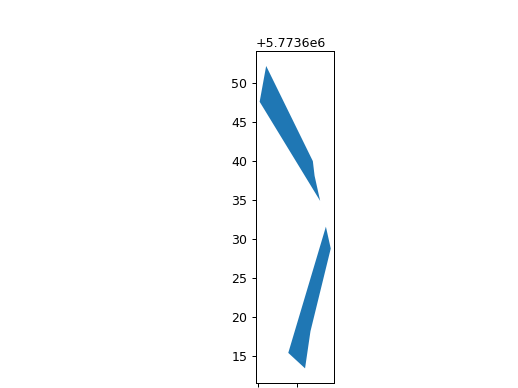

<AxesSubplot:>

In [46]:
test.plot()

In [ ]:
type(pts_gdf.iloc[0]['coordinates'])

In [ ]:
from shapely.geometry import Point

In [ ]:
isinstance(pts_gdf.iloc[0]['location'],str)

In [ ]:
f,ax=plt.subplots()

#to_clean_classified.query("point_id=='3300o21753081509le201'").plot(ax=ax)
#subset_finetune_polys[-2:].plot(column='index', alpha=.3, ax=ax)
intersection_gdf.reset_index().plot(ax=ax, column='index')

In [ ]:
to_update_finetune.query("point_id=='3300o21753081509le201'")

In [ ]:
crs_dict_string
